# Handling One Walking Case

---

Walking Bout Detection

    We will start by dividing the dataset in walking bouts so we can properly get metrics from each of them.

    The dataset should consist on an array of x,y,z accelerometer values. This code is done for a collection of values in the frequency of 100Hz.
    To start off, we import the functions and packages we will need for the processing.

    The dataset is located in a folder, which we can get hold off through pandas package. In this dataset, there is no header, so we should specify that.


In [1]:
from scripts.walking_bouts import *
from scripts.visualization import showCharts

In [4]:
file = '32315_A.Sampaio_Jun19_Trunk_Walk.csv'

In [5]:
data = pd.read_csv('./data/walk/' + file, header = None)
data.head()

,0,1,2,3
0,1.560530e+09,-1.046875,-0.093750,-0.125
1,1.560530e+09,-1.062500,-0.093750,-0.125
2,1.560530e+09,-1.046875,-0.093750,-0.125
3,1.560530e+09,-1.046875,-0.093750,-0.125
4,1.560530e+09,-1.046875,-0.078125,-0.125


In [6]:
# Create a copy of the values in order to do a WalkingBoutDetection    
data_wb = data.copy()

### Signal Processing

    We need to do some adjustments to the signal before running a walking bouts detection.
    1. We subtract the average so the signal is centered on 0
    2. We filter the signal for values above 17Hz

In [7]:
applyOffsetRemove(data_wb)
applyFilter(data_wb)  # 'df' will be used inside the next function

In [8]:
window = 200
ssd_threshold = 0.1
scale_threshold = [7.5,30]
minimum = 500 # 5 segundos

In [9]:
from pywt import ContinuousWavelet, scale2frequency
wavelet = ContinuousWavelet("gaus2")
f_up = scale2frequency(wavelet, 30)/0.01
f_down = scale2frequency(wavelet, 7.5)/0.01

print(f"Upper threshold = {f_up}Hz\nLower threshold = {f_down}Hz")

Upper threshold = 1.0Hz
Lower threshold = 4.0Hz


started window


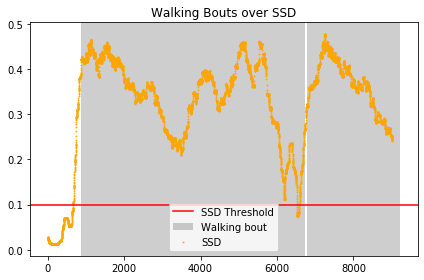

In [11]:
ranges_ww = runWalkingBoutDetection(
                data_wb,
                ssd_threshold,
                window,
                minimum,
            )

In [12]:
for a in ranges_ww:
    print(f"From {a[0]} to {a[1]}")

From 667 to 6521
From 6588 to 9019


---

## Extracting Info from JSON files

    The following function will extract from the patient files the number of steps that they gave during their walk segments (normally 3 segments)

In [13]:
from reports.scripts.get_info_reports import *
real_steps = getReportStepsFromCsv(file.split('.csv')[0])

for i, steps in enumerate(real_steps):
    print(f"Number of steps in segment {i+1} = {steps}")

Number of steps in segment 1 = 24
Number of steps in segment 2 = 25
Number of steps in segment 3 = 21


    While this next one gets various useful information from the file iteself

In [14]:
patientInfo = getPatientInfo(file)
patientInfo

{'name': 'A.Sampaio',
 'age': 89,
 'height': '176',
 'weight': '79.3',
 'code': '3384'}

---

## Signal Processing

In [15]:
from scripts.signal_processing import *
from matplotlib import pyplot as plt
import pandas as pd

    First we select the data that we want to process

In [18]:
walk = 0  # DIOGO: É preciso ajustar aqui o walk segment do walking bout

In [19]:
segment = ranges_ww[walk]

In [20]:
data_w = data[segment[0]:segment[1]+window]

    Since the accelerometer was tilted in the trunk of a person. The values need to be corrected. This can be achieved through calculus contained in the H_V_orth_sys function.

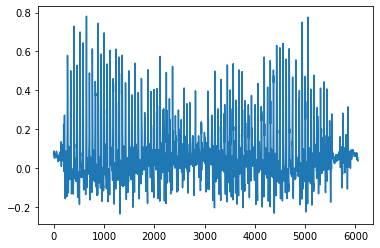

In [21]:
data_w = H_V_orth_sys(data_w, True)
plt.plot(range(len(data_w[1])), data_w[1])

    Sadly, this signal is cut between two walks, but it should still suffice to gather the metrics that are needed.  
    We continue with detrending the data. No trend should exit in the dataset, since it should always tend near an average value. Any trend is an error and should be eliminated.

In [22]:
data_w = detrend_data(data_w)

    Then we can proceed with filtering the signal for all frequencies above 20Hz. This should help in reducing noise from the signal.

In [23]:
fs = 100 # Hz
cut_frequency = 20 # Hz
order = 4
btype = 'low'
data_w = butter_bp_data(data_w,cut_frequency,fs,order,btype)

---

## Identification of ICs and FCs

    Now that we have attempted to clear the signal of any noise and fixed the axis, we can identify the Initial Contact (IC) and Final Contact (FC) times. 
    These will allow us to calculate the relevant metrics.


In [24]:
from scripts.detection_ic_fc import *
from scripts.visualization import *

    To start we have to get the velocity in the vertical axis (Vz) by integrating the vertical acceleration (Az).
    This function uses integrate package to integrate through cummulative trapezoids over the dataset period. 

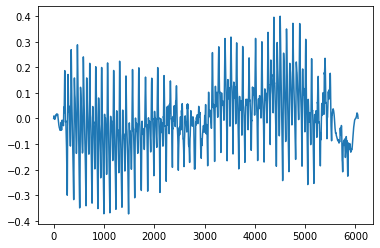

In [25]:
Vz = integrate_Hz(data_w[1], 100, True)
plt.plot(range(len(Vz)), Vz)

### Detecting Scale

    To help with the IC and FC detection we will detect the best frequency detected in the z-axis velocity

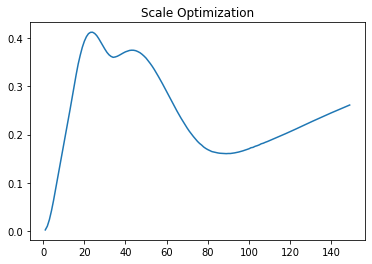

Scale to be used = 23


In [26]:
index = identify_scale(Vz, plot_this = True)
print(f"Scale to be used = {index}")

    Following the literature provided, we could use use a scale of 10, but instead here we are using the best detected frequency above.
    After the first cwt we detect the minimum peaks with a threshold of 0.65 (meaning that all peaks have to be over 65% of the global minimum) - this will indicate the IC events.
    With a second cwt we detect the maximum peaks, also with a threshold of 0.65 - these will be the FC events.

In [27]:
scale = index  # DIOGO: É preciso ajustar aqui a frequencia de ICs e FCs. 
# Se a optimização não funcionar, é preciso mudar aqui (para 20 talvez?)

thres = 0.65

cwt_1, cwt_2, IC, FC = IC_FC_detection(Vz, scale, thres)

    To help us understand the ammount of steps we are detecting and how 'perfect' the dataset is, we can visualize below:

    * All blue dots indicate the FC events;
    * All red crosses indicate the IC events;
    * There should be an equal number of IC and FC events, one after the other;
    * Its a bad sign if the values any not equally dispersed

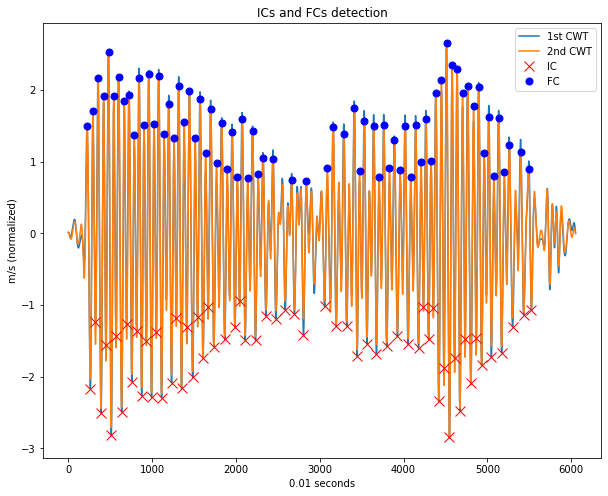

In [28]:
legend = ['1st CWT','2nd CWT','IC','FC']
title = 'ICs and FCs detection'
IC_values = [IC,normalize(cwt_1)[IC]]
FC_values = [FC,normalize(cwt_2)[FC]]

visualize_signal(legend, title, normalize(cwt_1), normalize(cwt_2), IC = IC_values, FC = FC_values)

    Since many times we are not getting the same number of FC and IC events, 
    or it is detecting events too close together, we need to optimize the events.
    The function below will work in that sense.

    We proceed in the second code cell with the same visualization as before.

In [29]:
new_IC, new_FC = optimize_IC_FCs(IC, FC)

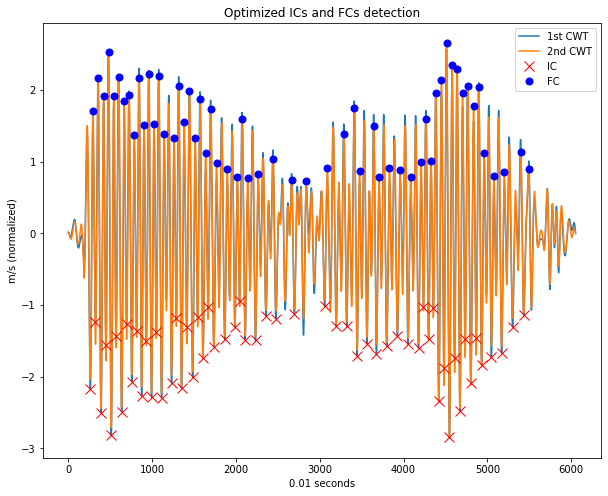

In [30]:
legend = ['1st CWT','2nd CWT','IC','FC']
title = 'Optimized ICs and FCs detection'
IC_values = [new_IC,normalize(cwt_1)[new_IC]]
FC_values = [new_FC,normalize(cwt_2)[new_FC]]

visualize_signal(legend, title, normalize(cwt_1), normalize(cwt_2), IC = IC_values, FC = FC_values)

---

## Extracting Metrics

    Now that we have the IC and FC events we can extract the gait metrics.

In [31]:
from scripts.metrics_extraction import *
from reports.scripts.get_info_reports import *
from scripts.metrics_table import *

    We must first prepare some extra data for the measure of step length:
    1. The Variation in Height (h)
    2. The Height of the Patient. Preferably this value is accessible automatically.

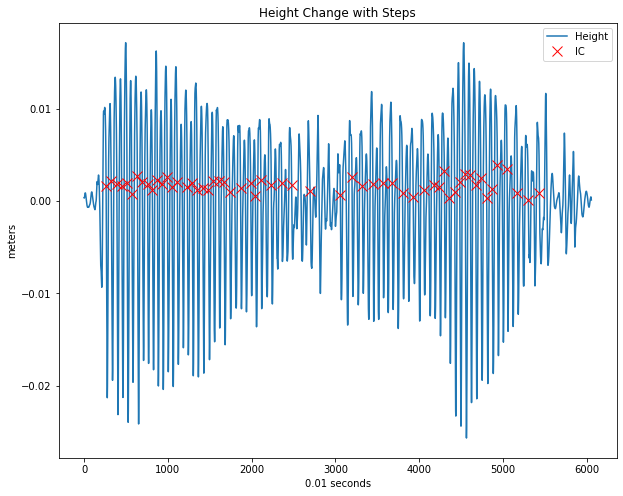

In [32]:
h = integrate_Hz(Vz)
h = butter_bandpass_filter(h, 1, fs, btype='high') # Need to validate this

legend = ['Height','IC']
title = 'Height Change with Steps'
IC_values = [new_IC,h[new_IC]]

visualize_signal(legend, title, h, ylabel = 'meters', IC = IC_values)

In [33]:
patient_height = float(patientInfo['height'])

if patient_height > 100:
    patient_height = patient_height / 100
    
print(f"Patient Height is {patient_height} m")

Patient Height is 1.76 m


    We start by attaining the averages:

In [34]:
stride_avg , stride = get_gait_stride(new_IC, new_FC)
cadence = get_cadence(new_IC)
step_avg, step = get_gait_step(new_IC)
steplen_avg, steplen = get_gait_stepLen(h, new_IC, patient_height)
strideLen_avg, strideLen = get_gait_strideLen(steplen)
stepv_avg, stepv = get_gait_velocity(steplen, step)
stance_avg, stance = get_gait_stance(new_IC, new_FC)
swing_avg, swing = get_gait_swing(stance, stride)
dsupport_time_avg, dsupport_time = get_gait_doublesupport(new_IC, new_FC)

    Then we get the variabilities (2 methods) for each of these measures. 
    Variability A checks for the variability of Right and Left seperately.
    Variability B checks for the variability of all the steps.

In [35]:
stride_var_b = variability_b(stride)
steplen_var_b = variability_b(steplen)
step_var_b = variability_b(step)
stepv_var_b = variability_b(stepv)
stance_var_b = variability_b(stance)
swing_var_b = variability_b(swing)
dsupport_var_b = variability_b(dsupport_time)

    To finalize we have the asymmetry which measures the difference in averages of both right and left steps

In [36]:
stride_asy = asymmetry(stride)
step_asy = asymmetry(step)
stance_asy = asymmetry(stance)
swing_asy = asymmetry(swing)
steplen_asy = asymmetry(steplen)

    We can organize the values in a dictionary to add to a pandas DataFrame

In [37]:
values = {
    "Gait Velocity": stepv_avg,
    "Cadence": cadence,

    "Stance phase": np.nan,
    "Swing phase": np.nan,
    "Double support phase": np.nan,

    "Stride length": strideLen_avg,
    "Stride velocity": (strideLen_avg / stride_avg),
    "Step time": step_avg,
    "Step length": steplen_avg,
    "Step velocity": stepv_avg,
    "Stance time": stance_avg,
    "Swing time": swing_avg,
    "Double support time": dsupport_time_avg,

    "Stride time variability": stride_var_b,
    "Step length variability": steplen_var_b,
    "Step time variability": step_var_b,
    "Step velocity variability": stepv_var_b,
    "Stance time variability": stance_var_b,
    "Swing time variability": swing_var_b,
    "Double support variability": dsupport_var_b,
    
    "Stride time asymetry": stride_asy,
    "Step time asymetry": step_asy,
    "Stance time asymetry": stance_asy,
    "Swing time asymetry": swing_asy,
    "Step length asymetry": steplen_asy,
    "Number of Steps": len(new_IC),
}

In [38]:
df = create_table(**values)

    The comparison values are taken from a paper to see if they diverge too much from real results taken from a GaitRite

In [39]:
comparison_values = {
    "Gait Velocity": 1.26,
    "Cadence": 100,

    "Stance phase": np.nan,
    "Swing phase": np.nan,
    "Double support phase": np.nan,

    "Stride length": np.nan,
    "Stride velocity": np.nan,
    "Step time": 0.554,
    "Step length": 0.69,
    "Step velocity": 1.26,
    "Stance time": 0.715,
    "Swing time": 0.393,
    "Double support time": np.nan,

    "Stride time variability": np.nan,
    "Step length variability": 0.023,
    "Step time variability": 0.016,
    "Step velocity variability": 0.058,
    "Stance time variability": 0.022,
    "Swing time variability": 0.016,
    "Double support variability": np.nan,
    
    "Stride time asymetry": np.nan,
    "Step time asymetry": 0.010,
    "Stance time asymetry": 0.020,
    "Swing time asymetry": 0.010,
    "Step length asymetry": 0.022,
    "Number of Steps": real_steps[walk],
}

In [40]:
df2 = create_table(**comparison_values)

In [41]:
pd.concat([df,df2]).T

,0,0
Gait Velocity,0.592348,1.260
Cadence,67.298395,100.000
Stance phase,NaN,NaN
Swing phase,NaN,NaN
Double support phase,NaN,NaN
Stride length,0.884686,NaN
Stride velocity,0.488199,NaN
Step time,0.907193,0.554
Step length,0.441998,0.690
Step velocity,0.592348,1.260
